In [1]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils.quack import Quack
from sim_utils.modeling import update_config, maskedModel, ResBlock, FocalLoss, FocalLossSoft, adjacent_label_smoothing #noqa
torch.cuda.is_available()

True

In [2]:
rusher_stat_cols =[
 'carries_roll',
 'rushing_yards_roll',
 #'rushing_tds_roll',
 #'rushing_first_downs_roll',
 #'receiving_yards_roll',
 #'receiving_tds_roll',
 #'fantasy_points_ppr_roll',
 'yards_per_carry_roll']

team_stat_cols = [
 #'completions_team_roll',
 #'attempts_team_roll',
 'carries_team_roll',
 #'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'yards_per_carry_team_roll',
]
opp_stat_cols = [
#'completions_opp_roll',
 #'attempts_opp_roll',
 'carries_opp_roll',
 #'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll',
 'yards_per_carry_opp_roll',
]

game_context_cols = [
	"yardline_100",
	"ydstogo",
	"down",
	"goal_to_go",
	#"posteam_score",
	#"defteam_score",
	#"score_differential",
	#'quarter_seconds_remaining',
	#'half_seconds_remaining',
	#'game_seconds_remaining',
	#"wind",
	#"temp",
	'spread_line',
	'total_line',
]

adv_cols = ['stuffed','mediocre', 'explosive', 'huge_play', 'first_down', 'short_first', 'epa']

x_cols = game_context_cols + adv_cols #+ ['is_first_down', 'is_second_down', 'is_third_down','is_fourth_down', 'touchdown', 'short_to_first'] # + rusher_stat_cols + ['run_gap_encoded'] + rusher_stat_cols + team_stat_cols + opp_stat_cols 

In [3]:
rushes = Quack.query(f"""
select pbp.desc,pbp.game_id, pbp.yards_gained,pbp.yards_gained + 40 as yards_shifted,
	case when pbp.down = 1 then 1 else 0 end as is_first_down,
	case when pbp.down = 2 then 1 else 0 end as is_second_down,
	case when pbp.down = 3 then 1 else 0 end as is_third_down,
	case when pbp.down = 4 then 1 else 0 end as is_fourth_down,
	pbp.first_down, pbp.touchdown
    ,rusher_player_name
    ,rusher_id,
                     pbp.season,
					 pbp.week,
                     fantasy_player_name,
                     qb_scramble,
	case when pbp.ydstogo < 3 then 1 else 0 end as short_to_first,
	adv.*,
	{Quack.select_columns(game_context_cols, alias='pbp', coalesce=True)},
	--{Quack.select_columns(team_stat_cols, alias='t', coalesce=True)},
	--{Quack.select_columns(opp_stat_cols, alias='o', coalesce=True)},
	--{Quack.select_columns(rusher_stat_cols, alias='r', coalesce=True)}
	from pbp 
	join rusher_adv as adv on pbp.rusher_player_id = adv.gsis_id
	and pbp.season = adv.season
	and pbp.week = adv.week
	--join team_feats as t 
	--on pbp.posteam = t.team
	--and pbp.game_id = t.game_id
	--join opp_feats as o
	--on pbp.defteam = o.opponent_team
	--and pbp.game_id = o.game_id
	--join player_weekly_agg as r
	--on r.game_id = pbp.game_id
	--and pbp.rusher_player_id = r.gsis_id
	--and r.team = pbp.posteam
	where pbp.play_type = 'run'
	and pbp.yards_gained is not null
	and pbp.down is not null
	and pbp.penalty = 0
	and pbp.fumble = 0
""")

rushes2 = rushes.copy()
mask = rushes.yards_gained < (rushes.yardline_100 - 10)
rushes2.loc[mask, 'yards_shifted'] += np.random.randint(-2,3, size=mask.sum())
print(len(rushes2))


264860


In [4]:
rushes[x_cols]

,yardline_100,ydstogo,down,goal_to_go,spread_line,total_line,stuffed,mediocre,explosive,huge_play,first_down,short_first,epa
0,67.0,10.0,1.0,0.0,4.5,41.5,0.214847,0.345781,0.107356,0.025105,0.0,0.651492,-0.052808
1,11.0,4.0,2.0,0.0,4.5,41.5,0.214847,0.345781,0.107356,0.025105,0.0,0.651492,-0.052808
2,10.0,3.0,3.0,0.0,4.5,41.5,0.516621,0.164095,0.080874,0.008644,0.0,0.667586,-0.412657
3,80.0,10.0,1.0,0.0,4.5,41.5,0.214943,0.341304,0.090539,0.008725,1.0,0.603167,-0.076041
4,59.0,2.0,2.0,0.0,4.5,41.5,0.214943,0.341304,0.090539,0.008725,1.0,0.603167,-0.076041
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264855,86.0,1.0,3.0,0.0,4.5,41.5,0.214847,0.345781,0.107356,0.025105,1.0,0.651492,-0.052808
264856,54.0,20.0,1.0,0.0,4.5,41.5,0.214847,0.345781,0.107356,0.025105,0.0,0.651492,-0.052808
264857,83.0,5.0,2.0,0.0,4.5,41.5,0.214943,0.341304,0.090539,0.008725,0.0,0.603167,-0.076041
264858,11.0,10.0,1.0,0.0,2.5,36.5,0.247624,0.212603,0.151889,0.016643,0.0,0.701174,0.012805


In [5]:
data = rushes #pd.concat((rushes, rushes2))
X = data[x_cols]
y = data['yards_shifted']
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)
#X_td = rushes.loc[rushes.touchdown==1][x_cols].copy().reset_index(drop=True)
#y_td = rushes.loc[rushes.touchdown==1]['yards_shifted'].copy().reset_index(drop=True)

In [6]:
(data['yardline_100'] - data['yards_shifted']).max()

np.float64(60.0)

In [7]:
def train_model(X, y, n_in, n_out,n_hidden=50, epochs=20, batch_size=128, model=None):
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	print(device)
	X = X.to(device)
	y = y.to(device)

	print('tensors loading')
	#smoothed_y = adjacent_label_smoothing(y,X[:,0], num_classes=140, smoothing = 0.1)

	if not model:
		model = maskedModel(
		n_in=n_in,
		n_out=n_out,
		n_hidden=n_hidden,
		).to(device)
	#criterion = FocalLoss(gamma=2)
	criterion = nn.CrossEntropyLoss()
	td_criterion = nn.BCELoss()
	fd_criterion = nn.BCELoss()
	criterion_mse = nn.MSELoss()
	optimizer = optim.Adam(model.parameters(), lr=0.0009, weight_decay=0.008)

	num_samples = X.size(0)
	indices = torch.randperm(num_samples, device=device)

	# Calculate train-test split sizes
	split = num_samples // 5  # 20% test data
	test_indices = indices[:split]
	train_indices = indices[split:]

	# Create train-test splits using the shuffled indices
	print('splitting batches')
	Xtr = X[train_indices].to(device)
	Xtst = X[test_indices].to(device)
	train_y = y[train_indices].to(device)
	#train_y_smooth = smoothed_y[train_indices].to(device)
	test_y =  y[test_indices].to(device)
	#test_y_smooth = smoothed_y[test_indices].to(device)
	train_is_td = (y[train_indices] == (40 +  Xtr[:,0])).float()
	train_is_fd = (y[train_indices] >= (40 + Xtr[:,1])).float()
	print(train_is_fd.mean())
	print(train_is_td.mean())
	# Training loop

	for epoch in range(epochs):
		model.train()
		permutation = torch.randperm(Xtr.size(0))
		epoch_mean_loss = 0
		epoch_class_loss = 0

		for i in range(0, Xtr.size(0), batch_size):
			batch_idx = permutation[i:i + batch_size]
			batch_x, batch_y = Xtr[batch_idx], train_y[batch_idx]
			#batch_y_smooth =  train_y_smooth[batch_idx]
			batch_td, batch_fd = train_is_td[batch_idx], train_is_fd[batch_idx]

			optimizer.zero_grad()
			outputs = model(batch_x)  # Shape: [batch_size, n_out]
			probs = torch.softmax(outputs, dim=1)


			fd_mask = torch.arange(probs.size(1), device=device).unsqueeze(0) >= (batch_x[:,1] + 40).unsqueeze(1) + 1e-6  # [9, 140]
			fd_output = (probs * fd_mask).sum(1)
			td_mask = torch.arange(probs.size(1),device=device).unsqueeze(0) >= (batch_x[:,0] + 40).unsqueeze(1) + 1e-6  # [9, 140]
			td_output = (probs * td_mask).sum(1)
			td_loss = td_criterion(td_output, batch_td) * 2
			fd_loss = fd_criterion(fd_output, batch_fd) * 0.5

			probs_mean = (torch.arange(0,n_out, dtype=torch.float32).to(device) * probs).sum(1)
			classifier_loss = criterion(outputs, batch_y)
			mean_loss =  criterion_mse(probs_mean, batch_y.float()) * 1.5
			loss = classifier_loss + mean_loss + td_loss + fd_loss
			#loss = classifier_loss + td_loss
			loss.backward()
			optimizer.step()

			epoch_mean_loss += mean_loss.item()
			epoch_class_loss += classifier_loss.item()
		n_batches = len(range(0, Xtr.size(0), batch_size))
		print(f"Epoch {epoch+1}/{epochs}, Classifier Loss: {epoch_class_loss/n_batches:.4f}, MSE Loss: {epoch_mean_loss/n_batches:.4f}")


		model.eval()
		with torch.no_grad():
			test_preds = model(Xtst)
			test_loss = criterion(test_preds, test_y).item() 
			accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()
		print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")
	return model

In [8]:

rush_yards_model = train_model(X_tensor,y_tensor, n_in=len(x_cols), n_out=140, n_hidden = 128, epochs=20, batch_size=2048)

#Test Loss: 2.3133, Test Accuracy: 0.1709 
#Test Loss: 2.8949, Test Accuracy: 0.1649 add label smoothing, no focal loss
#Test Loss: 2.4887, Test Accuracy: 0.1709 smoothing + focal + remove 1st down leakage
#Test Loss: 2.4681, Test Accuracy: 0.1682 maskedmodel2
#Test Loss: 2.4735, Test Accuracy: 0.1648 hierarchical thing
#Test Loss: 2.4042, Test Accuracy: 0.1596 
#Test Loss: 2.8056, Test Accuracy: 0.1470 fixed td bug, this looks best even w/ low acc. no focal loss or smooth labels
#Test Loss: 2.9683, Test Accuracy: 0.1199
#

cuda
tensors loading
splitting batches
tensor(0.2387, device='cuda:0')
tensor(0.0333, device='cuda:0')
Epoch 1/20, Classifier Loss: 6.1136, MSE Loss: 102.6809
Test Loss: 3.9214, Test Accuracy: 0.0697
Epoch 2/20, Classifier Loss: 4.4282, MSE Loss: 51.3312
Test Loss: 4.8775, Test Accuracy: 0.0644
Epoch 3/20, Classifier Loss: 4.7252, MSE Loss: 38.5621
Test Loss: 4.6733, Test Accuracy: 0.0678
Epoch 4/20, Classifier Loss: 4.2960, MSE Loss: 34.0161
Test Loss: 4.0561, Test Accuracy: 0.0693
Epoch 5/20, Classifier Loss: 3.8747, MSE Loss: 33.3093
Test Loss: 3.7290, Test Accuracy: 0.0711
Epoch 6/20, Classifier Loss: 3.5984, MSE Loss: 32.9944
Test Loss: 3.5070, Test Accuracy: 0.0754
Epoch 7/20, Classifier Loss: 3.3910, MSE Loss: 33.1383
Test Loss: 3.3982, Test Accuracy: 0.0766
Epoch 8/20, Classifier Loss: 3.2693, MSE Loss: 32.7292
Test Loss: 3.2246, Test Accuracy: 0.0776
Epoch 9/20, Classifier Loss: 3.1658, MSE Loss: 32.7126
Test Loss: 3.0582, Test Accuracy: 0.0799
Epoch 10/20, Classifier Loss: 3.

In [9]:

rush_yards_model = rush_yards_model.to('cpu')
model_path = "models/run_yards_gained.pt"
torch.save(rush_yards_model.state_dict(), model_path)


feature_config = {
	'rush_yard_cols':x_cols
}
feature_config

update_config(feature_config)

true_first=0.11, true_td=0.06
fd_model=0.12, td_model=0.07
Actual mean: 3.80, Model mean: 3.72
number of datapoints: 1127


(-10.0, 34.0)

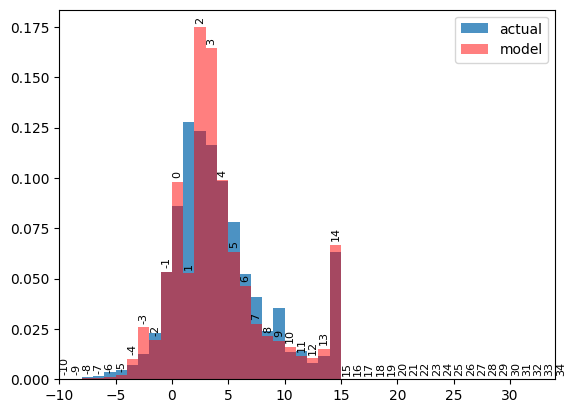

In [10]:
def get_ydl_chance(probs, ydl):

	cols = np.arange(probs.shape[1])
	mask = cols >= ydl[:, None]   # shape (3, 10), True where col >= start
	sums = (probs * mask).sum(axis=1).mean()
	return sums

def sample_model_yardline(yard, down):
	sample = rushes.loc[(rushes.yardline_100 == yard) & (rushes.down.between(1,1))].reset_index(drop=True)
	true_first = sample['first_down'].mean().item()
	true_td = sample['touchdown'].mean().item()
	print(f"{true_first=:.2f}, {true_td=:.2f}")
	inp =  sample[x_cols]
	y = sample['yards_gained']

	inp = torch.tensor(inp.values, dtype=torch.float32)
	out = rush_yards_model(inp).detach().numpy()
	exp_logits = np.exp(out - np.max(out, axis=1, keepdims=True))
	probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
	td_model = get_ydl_chance(probs, sample['yardline_100'].values + 40).item()
	fd_model = get_ydl_chance(probs, sample['ydstogo'].values + 40).item()
	print(f"{fd_model=:.2f}, {td_model=:.2f}")
	probs = probs.mean(axis=0)
	

	plt.hist(y, range(-40,101),width=1, density=True, alpha=0.8, label='actual')

	actual_mean = y.mean()
	model_mean = (np.arange(len(probs)) - 40) @ probs
	print(f"Actual mean: {actual_mean:.2f}, Model mean: {model_mean:.2f}")
	print(f'number of datapoints: {len(inp)}')
	return probs

yard = 14
down = 2
probs = sample_model_yardline(yard, down)
plt.bar(range(-40, 100), probs, width=1, alpha=0.5, align="edge", label="model", color='r')
3
# Add index labels on top of bars
for i, p in enumerate(probs):
	yard_val = -40 + i
	if -10 <= yard_val <= yard + 20:  # only label visible range
		plt.text(yard_val + 0.5, p + 0.002, str(yard_val),
				 ha='center', va='bottom', fontsize=8, rotation=90)


plt.legend()
plt.xlim(-10,yard+20)

In [11]:
def sample_model_yardline(yard, down):
	sample = rushes#.loc[(rushes.yardline_100 == yard) & (rushes.down.between(1,1))].reset_index(drop=True)
	true_first = sample['first_down'].mean().item()
	true_td = sample['touchdown'].mean().item()
	print(f"{true_first=:.2f}, {true_td=:.2f}")
	inp =  sample[x_cols]
	y = sample['yards_gained']

	inp = torch.tensor(inp.values, dtype=torch.float32)
	out = rush_yards_model(inp).detach().numpy()
	exp_logits = np.exp(out - np.max(out, axis=1, keepdims=True))
	probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
	td_model = get_ydl_chance(probs, sample['yardline_100'].values + 40).item()
	fd_model = get_ydl_chance(probs, sample['ydstogo'].values + 40).item()
	print(f"{fd_model=:.2f}, {td_model=:.2f}")
	
	return probs

probs = sample_model_yardline(10,4)
probs

true_first=0.24, true_td=0.03
fd_model=0.21, td_model=0.03


array([[2.13834853e-12, 5.27486978e-11, 2.41241489e-11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.81730844e-08, 1.40806279e-07, 5.99777294e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.35903635e-08, 9.50844949e-08, 4.23409006e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [7.44392951e-14, 1.65310344e-12, 7.72886909e-13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.07274045e-08, 4.02412553e-07, 1.65802177e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.08807796e-12, 1.19169521e-10, 5.12461532e-11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
      shape=(264860, 140), dtype=float32)

In [12]:
rushes['pred'] = torch.sum(torch.tensor((probs * np.arange(-40,100))),dim=1)
rushes

,desc,game_id,yards_gained,yards_shifted,is_first_down,is_second_down,is_third_down,is_fourth_down,first_down,touchdown,...,week_1,name,gsis_id,yardline_100,ydstogo,down,goal_to_go,spread_line,total_line,pred
0,(13:50) 30-A.Green left tackle to GB 35 for 2 ...,2002_09_MIA_GB,2.0,42.0,1,0,0,0,0.0,0.0,...,9,Ahman Green,00-0006305,67.0,10.0,1.0,0.0,4.5,41.5,2.809843
1,(11:20) 30-A.Green left guard to MIA 10 for 1 ...,2002_09_MIA_GB,1.0,41.0,0,1,0,0,0.0,0.0,...,9,Ahman Green,00-0006305,11.0,4.0,2.0,0.0,4.5,41.5,1.088691
2,(10:36) 4-B.Favre left end to MIA 9 for 1 yard...,2002_09_MIA_GB,1.0,41.0,0,0,1,0,0.0,0.0,...,9,Brett Favre,00-0005106,10.0,3.0,3.0,0.0,4.5,41.5,0.442964
3,(9:47) 34-R.Williams left end pushed ob at MIA...,2002_09_MIA_GB,13.0,53.0,1,0,0,0,1.0,0.0,...,9,Ricky Williams,00-0017915,80.0,10.0,1.0,0.0,4.5,41.5,16.005887
4,(8:45) 34-R.Williams right end ran ob at MIA 4...,2002_09_MIA_GB,6.0,46.0,0,1,0,0,1.0,0.0,...,9,Ricky Williams,00-0017915,59.0,2.0,2.0,0.0,4.5,41.5,6.187116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264855,(6:38) 30-A.Green right guard to GB 24 for 10 ...,2002_09_MIA_GB,10.0,50.0,0,0,1,0,1.0,0.0,...,9,Ahman Green,00-0006305,86.0,1.0,3.0,0.0,4.5,41.5,4.546989
264856,(3:54) 30-A.Green up the middle to MIA 49 for ...,2002_09_MIA_GB,5.0,45.0,1,0,0,0,0.0,0.0,...,9,Ahman Green,00-0006305,54.0,20.0,1.0,0.0,4.5,41.5,4.392281
264857,(2:43) 34-R.Williams right end to MIA 14 for -...,2002_09_MIA_GB,-3.0,37.0,0,1,0,0,0.0,0.0,...,9,Ricky Williams,00-0017915,83.0,5.0,2.0,0.0,4.5,41.5,1.530451
264858,(12:27) 8-D.Carr right end to CIN 6 for 5 yard...,2002_09_CIN_HOU,5.0,45.0,1,0,0,0,0.0,0.0,...,9,David Carr,00-0020608,11.0,10.0,1.0,0.0,2.5,36.5,2.612792


In [13]:
rushes['RYOE'] = rushes['yards_gained'] - rushes['pred']


In [14]:
ex = rushes.loc[rushes.season ==2025].groupby(['rusher_player_name', 'qb_scramble'])['RYOE'].mean().reset_index().sort_values(by='RYOE')
cnt = rushes.loc[rushes.season == 2025]['rusher_player_name'].value_counts().reset_index()
ex = ex.merge(cnt)
ex.loc[(ex['count'] > 40) & (ex.qb_scramble == 0)].sort_values(by='RYOE').tail(30)

,rusher_player_name,qb_scramble,RYOE,count
122,J.Jacobs,0.0,0.022105,108
123,C.McCaffrey,0.0,0.041222,129
125,T.Henderson,0.0,0.057721,41
127,I.Pacheco,0.0,0.075939,65
128,C.Brown,0.0,0.086169,84
129,J.Mason,0.0,0.098014,83
133,C.Skattebo,0.0,0.118434,96
134,C.Hubbard,0.0,0.149484,66
140,K.Walker,0.0,0.204321,92
141,R.Stevenson,0.0,0.225270,67


In [15]:
rushes.groupby('season')['RYOE'].mean()

season
2000   -0.167599
2001    0.002424
2002    0.240667
2003    0.105542
2004   -0.012460
2005    0.009488
2006    0.165318
2007    0.126960
2008    0.172111
2009    0.208697
2010    0.091152
2011    0.145509
2012    0.083650
2013    0.093694
2014    0.064712
2015    0.063284
2016    0.098227
2017    0.039982
2018    0.097063
2019    0.191204
2020    0.180289
2021    0.168197
2022    0.243121
2023    0.123858
2024    0.247293
2025    0.258925
Name: RYOE, dtype: float64

In [16]:
rushes.groupby(['qb_scramble'])[['yards_gained', 'RYOE']].mean()

,yards_gained,RYOE
qb_scramble,,
0.0,4.274930,0.119773
1.0,7.617799,0.568607


In [17]:
ex.loc[ex.rusher_player_name.str.contains('R.Dowdle')]

,rusher_player_name,qb_scramble,RYOE,count
181,R.Dowdle,0.0,0.826339,96


5.34


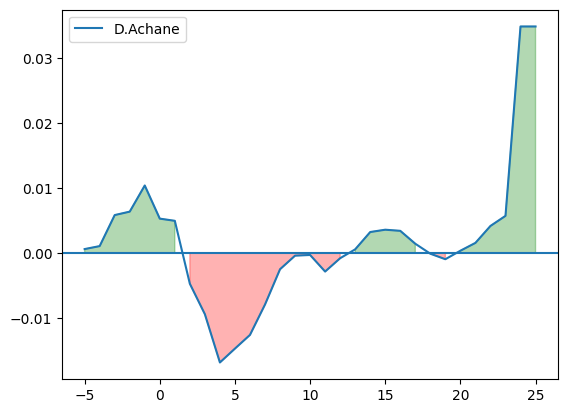

In [18]:
def vis_rusher(name):
	r1 = rushes.loc[
		(rushes.rusher_player_name == name) & (rushes.season == 2025), "yards_gained"
	]
	print(r1.mean().round(2))
	r1 = r1.apply(lambda x: max(-8,min(x, 25))).value_counts(normalize=True).reset_index()
	r_ = rushes.loc[
		(rushes.season >= 2023), "yards_gained"
	].apply(lambda x: max(-8,min(x, 25))).value_counts(normalize=True).reset_index()
	out = r1.merge(r_, on ='yards_gained', how='right')
	out['proportion_x'] = out['proportion_x'].fillna(0)
	out['di'] = (out['proportion_x'] - out['proportion_y']).fillna(0)
	out = out.sort_values(by='yards_gained')
	out['di'] = out['di'].rolling(5, min_periods=0, center=True).mean().rolling(3, min_periods=0, center=True).mean()
	out.loc[out.index[-1], 'di'] = out['proportion_x'].iloc[-1]
	out.loc[out.index[-2], 'di'] = out['proportion_x'].iloc[-1]
	out = out.loc[out.yards_gained > -6]
	plt.axhline(0)
	x = out['yards_gained']
	y = out['di']
	plt.plot(x,y, label=name)
	plt.fill_between(x, y, 0, where=(y>0), color='green', alpha=0.3)
	plt.fill_between(x, y, 0, where=(y<0), color='red', alpha=0.3)
	#plt.show()
	return out

out = vis_rusher('D.Achane')

#vis_rusher('C.McCaffrey')
plt.legend()

In [19]:
choices = rushes.loc[rushes.season==2025,'rusher_player_name'].value_counts().head(50).index.values

In [20]:
import ipywidgets as widgets
from IPython.display import display

# Create dropdown
dropdown = widgets.Dropdown(
    options=choices,
    value=choices[0],  # default value
    description='Choose:',
)


@widgets.interact(choice=choices)
def f(choice):
    vis_rusher(choice)


interactive(children=(Dropdown(description='choice', options=('B.Robinson', 'J.Taylor', 'C.McCaffrey', 'J.Will…